# VADER - Valence Aware Dictionary and sEntiment Reasoner

We will proceed to use vader as a representation of the reviews.  
VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.
The lexicon is sensitive both the polarity and the intensity of sentiments. It outputs 4 scoresL Positive, Neutral , Negative and Compund. The compund score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).
We will use it to project the reviews to a space of easier separability.

In [ ]:
#import nltk
#nltk.download('vader_lexicon')

In [137]:
import pandas as pd
import re
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from utils import Clustering_utils, Plotting_utils, Features_utils

In [38]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return [score['neg'],score['neu'],score['pos'],score['compound']]
    


In [39]:
# Load datasets
X_train = pd.read_csv('data/X_train.csv', header=None, names=['text'])
X_train['text'] = X_train['text'].apply(lambda text: re.sub('\n', '', text))
X_test = pd.read_csv('data/X_test.csv', header=None, names=['text'])
X_test['text'] = X_test['text'].apply(lambda text: re.sub('\n', '', text))
Y_train = pd.read_csv('data/Y_train.csv', header=None, names=['label'])
Y_test = pd.read_csv('data/Y_test.csv', header=None, names=['label'])

# Reviews to vectors

We will now build a function that uses the model to vectorize the reviews, and train a classifier over the projected space.

In [27]:
vader_scores_train = []
for text in X_train.text:
        scores = sentiment_analyzer_scores(text)
        vader_scores_train.append(scores)

In [28]:
vectorizedReviewsDF = pd.DataFrame.from_records(vader_scores_train)
vectorizedReviewsDF.to_csv('data/vectorized/train_vader_scores.csv',index=False)

# Gridsearch

We proceed to do a gridsearch with crossvalidation over **XGboost**  
We chose booosting algorithms because they scale nicely with the number of variables, are nonlinear and robust to noise, which we saw is what we need. Ther are also generally a great benchmark.

#### Since there is a tight time constraint, we will not do an exhaustive parameter space search. We will focus on showing the process of optimizing the models. It is very probable that we will arrive at overfited models or suboptimal parameters.

#### We will use fewer CV folds than reocmended, to accelerate training time. We will also try only a couple of parameters per algorithm. This will highly increase the probability of overfit.

#### Given that the classess are unbalanced, there will be a bias towards positive clasification. It is reccomended either for the observations to be weighted according to their unbalance or to use oversampling for the negative and neutral classes.

In [21]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# read vectorized reviews
X_trainVec = pd.read_csv('data/vectorized/train_vader_scores.csv')

#Generate model pipeline
XGB_pipeline = Pipeline([('model', XGBClassifier())])

#Gridsearch params
XGradientBoosting_param_grid = { 
    'model__objective':['multi:softmax'],
    'model__num_class':[3],
    'model__n_estimators': [300 ,1500],
    'model__booster': ['gbtree', 'dart'],
    'model__subsample': [1.0,0.4],
    'model__n_jobs':[4],
    'model__verbose':[False],
    'model__random_state' : [91]}

#search
grid = GridSearchCV(XGB_pipeline, param_grid=XGradientBoosting_param_grid, cv=2,verbose=4)
XGB_grid_result = grid.fit(X_trainVec, Y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False 
[CV]  model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False, score=0.790, total=  14.8s
[CV] model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s


[CV]  model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False, score=0.790, total=  14.8s
[CV] model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=0.4, model__verbose=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.6s remaining:    0.0s


[CV]  model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=0.4, model__verbose=False, score=0.790, total=  19.6s
[CV] model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=0.4, model__verbose=False 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.2s remaining:    0.0s


[CV]  model__booster=gbtree, model__n_estimators=300, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=0.4, model__verbose=False, score=0.790, total=  19.1s
[CV] model__booster=gbtree, model__n_estimators=1500, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False 
[CV]  model__booster=gbtree, model__n_estimators=1500, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False, score=0.790, total= 1.2min
[CV] model__booster=gbtree, model__n_estimators=1500, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verbose=False 
[CV]  model__booster=gbtree, model__n_estimators=1500, model__n_jobs=4, model__num_class=3, model__objective=multi:softmax, model__random_state=91, model__subsample=1.0, model__verb

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 576.2min finished


In [23]:
# Gridsearch results to dataframe
cvresults = pd.DataFrame.from_dict(XGB_grid_result.cv_results_)
cvresults = pd.concat([cvresults.drop('params',axis=1),cvresults.params.apply(pd.Series)],axis=1)
cvresults.to_csv('VADER_cvresultsRF_1.csv', index=False)
cvresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__booster,param_model__n_estimators,param_model__n_jobs,param_model__num_class,param_model__objective,param_model__random_state,...,std_test_score,rank_test_score,model__booster,model__n_estimators,model__n_jobs,model__num_class,model__objective,model__random_state,model__subsample,model__verbose
0,12.838375,0.043000,1.944955,0.012297,gbtree,300,4,3,multi:softmax,91,...,1.206484e-04,6,gbtree,300,4,3,multi:softmax,91,1.0,False
1,17.326064,0.260683,2.045563,0.010155,gbtree,300,4,3,multi:softmax,91,...,1.903109e-04,3,gbtree,300,4,3,multi:softmax,91,0.4,False
2,62.945812,0.094819,9.190737,0.111249,gbtree,1500,4,3,multi:softmax,91,...,2.268479e-05,8,gbtree,1500,4,3,multi:softmax,91,1.0,False
3,84.159938,1.134373,10.060416,0.031552,gbtree,1500,4,3,multi:softmax,91,...,2.273190e-04,1,gbtree,1500,4,3,multi:softmax,91,0.4,False
4,227.115137,1.951268,1.992457,0.009831,dart,300,4,3,multi:softmax,91,...,1.206484e-04,6,dart,300,4,3,multi:softmax,91,1.0,False
5,250.963804,0.244319,2.120658,0.009332,dart,300,4,3,multi:softmax,91,...,1.054090e-04,2,dart,300,4,3,multi:softmax,91,0.4,False
6,7179.216493,34.262828,9.496583,0.067857,dart,1500,4,3,multi:softmax,91,...,9.146655e-07,4,dart,1500,4,3,multi:softmax,91,1.0,False
7,9402.951480,574.382509,10.393914,0.034884,dart,1500,4,3,multi:softmax,91,...,1.141173e-04,5,dart,1500,4,3,multi:softmax,91,0.4,False


In [40]:
vader_scores_test = []
for text in X_test.text:
        scores = sentiment_analyzer_scores(text)
        vader_scores_test.append(scores)

In [41]:
vectorizedReviewsDF = pd.DataFrame.from_records(vader_scores_test)
vectorizedReviewsDF.to_csv('data/vectorized/test_vader_scores.csv',index=False)

# Testing

We proceed to evaluate the models performance over the test split (30%).  
We will use a common performance metric, **confusion matrix**, which measures the number of correctly and incorrectly classified examples. Helps to check the level of overfitting. It has the drawback that it must use a fixed threshold, thus, may be biased because the best threshold may not be the one used.

In [43]:
X_trainVec = pd.read_csv('data/vectorized/train_vader_scores.csv')
X_testVec = pd.read_csv('data/vectorized/test_vader_scores.csv')

# Build model with best params
xg = XGBClassifier(n_estimators= 1500,booster = 'gbtree',subsample= 0.4,objective= 'multi:softmax',num_class=3,random_state= 91,verbose=10,n_jobs=4)

#train
xg.fit(X_trainVec, Y_train)
#test
predicted_Y = xg.predict(X_testVec)
predicted_Y_train = xg.predict(X_trainVec)

### Visualization of projected space

We graph 1000 reviews projected on the vectors generated by VADER.  
We can observe that there the projected space offers a clear sperability of the reviews, making it easier for the model to fit the data.


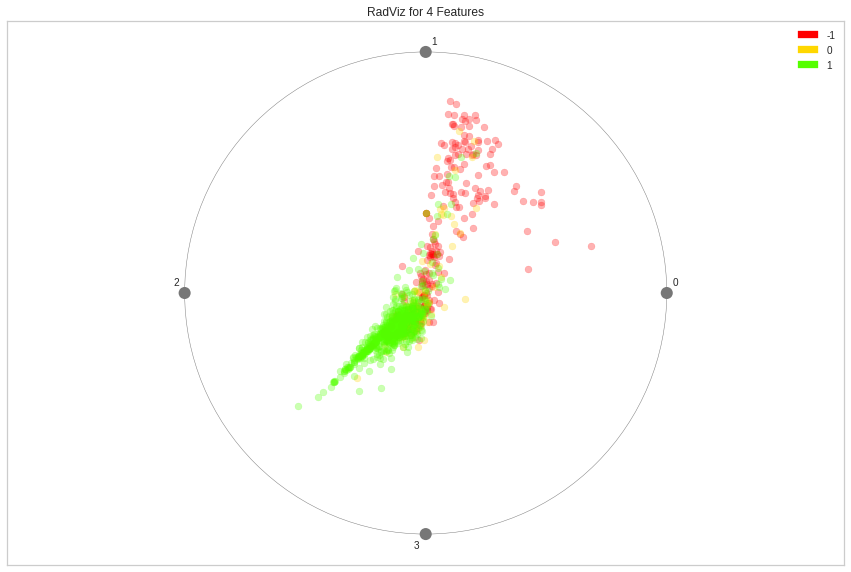

In [142]:
sample = np.random.choice(X_trainVec.shape[0],1000)
sample_X = X_trainVec.iloc[sample].reset_index(drop=True)
sample_Y = Y_train.iloc[sample].reset_index(drop=True)
#Radviz for best features
sample_Y_ = sample_Y['label'].apply(lambda x: 1 if x=='positive' else 0 if x=='neutral' else -1)
Plotting_utils.plot_RadViz(sample_X,sample_Y_)

Confusion matrix - Training 
 [[0.76 0.   0.24]
 [0.3  0.   0.7 ]
 [0.07 0.   0.93]]


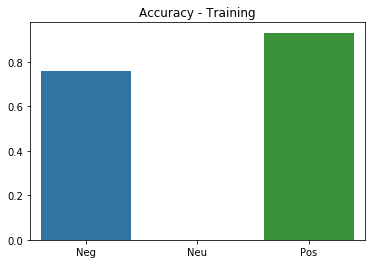

In [135]:
%matplotlib inline
cm = confusion_matrix(Y_train,predicted_Y_train)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Training \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Training")

Confusion matrix - Testing 
 [[0.76 0.   0.24]
 [0.3  0.   0.7 ]
 [0.07 0.   0.93]]


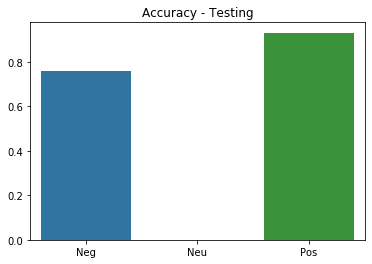

In [134]:
cm = confusion_matrix(Y_test,predicted_Y)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Testing \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Testing")

In [109]:
import pickle
# save model to file
pickle.dump(xg, open("models/VADER/xgboost_VADER.p", "wb"))
